# Context Aware Embeddings Visualization

This is a simple experiment, for learning-sake, to look at the word embeddings of difference sentences after they have passed through the attention mechanism of the transformer. I used a very simple transformer - gpt2 - and fed in 4 different sentences that have some ambiguity about the meaning of the word 'bark'. We can see that in the case of the sentence 'the dog bark' the 'bark' vector is pulled in the direction of 'dog', and in the case 'the tree bark', it's pulled in the direction of 'tree'. This shows how attention is adding context to these words based on the other words in the input.

/Users/brendanwhiting/.local/share/virtualenvs/mli-2024-06-coursework-l37Lgh_I/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/brendanwhiting/.local/share/virtualenvs/mli-2024-06-coursework-l37Lgh_I/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/brendanwhiting/.local/share/virtualenvs/mli-2024-06-coursework-l37Lgh_I/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


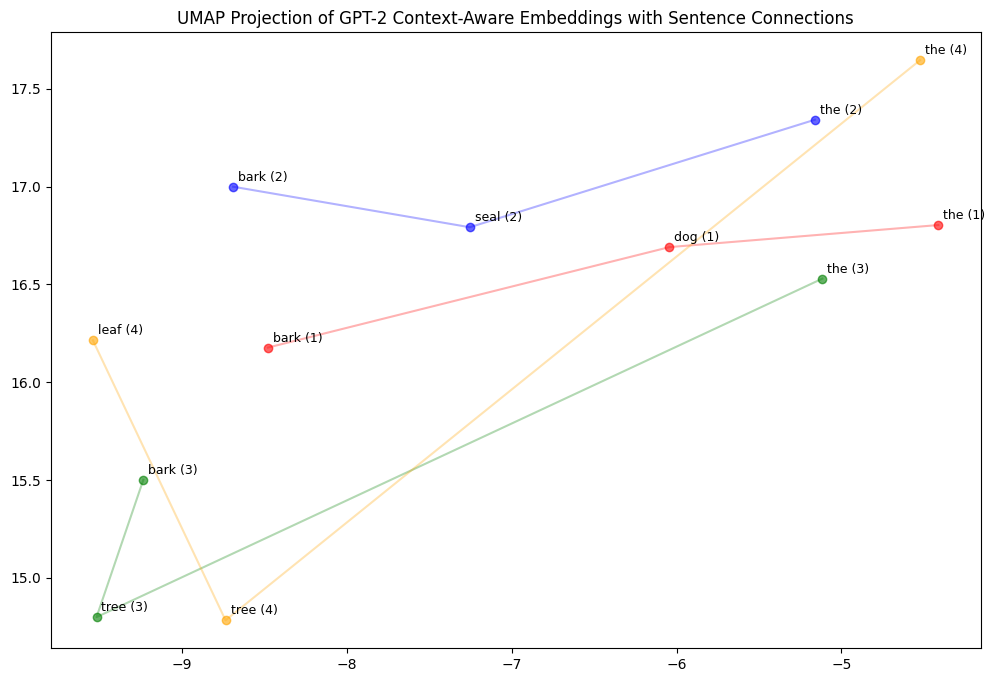

In [3]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
import umap
import matplotlib.pyplot as plt
import numpy as np

model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name, output_hidden_states=True)

tokenizer.pad_token = tokenizer.eos_token

sentences = [
    "the dog bark", 
    "the seal bark",
    "the tree bark",
    "the tree leaf"
]

sentence_colors = ['red', 'blue', 'green', 'orange']

all_embeddings = []
labels = []
colors = []
sentence_indices = []

for i, sentence in enumerate(sentences):
    tokens = tokenizer(sentence, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**tokens)
        hidden_states = outputs.hidden_states
    
    final_layer_embeddings = hidden_states[-1].squeeze().detach().numpy()   # Embeddings after all layers
    
    words = tokenizer.tokenize(sentence)
    sentence_id = f"({i+1})"
    
    def add_embeddings_and_labels(embeddings, words, sentence_id, all_embeddings, labels, colors, color, sentence_indices, sentence_num):
        for j, word in enumerate(words):
            all_embeddings.append(embeddings[j, :])
            labels.append(f'{word} {sentence_id}')
            colors.append(color)
            sentence_indices.append(sentence_num)
    
    add_embeddings_and_labels(final_layer_embeddings, words, sentence_id, all_embeddings, labels, colors, sentence_colors[i], sentence_indices, i)

def clean_label(label):
    cleaned_label = label.encode('ascii', 'ignore').decode('ascii')
    return cleaned_label

cleaned_labels = [clean_label(label) for label in labels]

reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42)
reduced_embeddings = reducer.fit_transform(all_embeddings)

plt.figure(figsize=(12, 8))

for I, label in enumerate(cleaned_labels):
    plt.scatter(reduced_embeddings[I, 0], reduced_embeddings[I, 1], color=colors[I], alpha=0.6)
    plt.text(reduced_embeddings[I, 0] + 0.03, reduced_embeddings[I, 1] + 0.03, label, fontsize=9)

# Draw lines between points of the same sentence
for I in range(len(sentences)):
    indices = [index for index, sentence_num in enumerate(sentence_indices) if sentence_num == I]
    plt.plot(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], color=sentence_colors[I], alpha=0.3)

plt.title('UMAP Projection of GPT-2 Context-Aware Embeddings with Sentence Connections')
plt.show()